# Sequential vs Sequential2D Comparison

This notebook compares PyTorch's built-in Sequential container with our custom Sequential2D container, demonstrating:

1. **Functional Equivalence**: Cases where both produce identical results
2. **Architectural Differences**: Unique capabilities of Sequential2D
3. **Performance Analysis**: Memory and computational efficiency comparisons
4. **Use Case Scenarios**: When to choose each approach

## Learning Objectives

- Understand the differences between linear sequential architectures and 2D block architectures
- Learn when Sequential2D provides advantages over standard Sequential
- Analyze performance trade-offs in different scenarios
- Gain insights into advanced neural network architecture design

In [1]:
# Import required libraries
import torch
import torch.nn as nn
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd
from iterativennsimple.Sequential2D import Sequential2D, Identity
from iterativennsimple.Sequential1D import Sequential1D

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")  # Force CPU for this example
print(f"Using device: {device}")

Using device: cuda


## Part 1: Functional Equivalence

Let's start by showing how Sequential2D can replicate the behavior of PyTorch's Sequential container.

In [2]:
def create_equivalent_networks():
    """
    Create functionally equivalent networks using Sequential and Sequential2D
    """
    # Network dimensions
    input_size = 784  # MNIST-like input
    hidden_size = 128
    output_size = 10
    
    f1 = nn.Linear(input_size, hidden_size)
    f2 = nn.Linear(hidden_size, hidden_size)
    f3 = nn.Linear(hidden_size, output_size)

    # PyTorch Sequential Network
    sequential_net = nn.Sequential(
        f1,
        nn.ReLU(),
        f2,
        nn.ReLU(),
        f3
    )
    
    in_features_list = [input_size, hidden_size, hidden_size, output_size]
    out_features_list = [input_size, hidden_size, hidden_size, output_size]
    
    # Create blocks matrix for linear chain
    I = Identity(in_features=input_size, out_features=input_size)
    # Note, the ReLU activations are included in the Sequential1D blocks, but can go different places
    # in the Sequential2D structure.
    F1 = Sequential1D(nn.Sequential(f1),            in_features=input_size,  out_features=hidden_size)
    F2 = Sequential1D(nn.Sequential(nn.ReLU(), f2), in_features=hidden_size, out_features=hidden_size)
    F3 = Sequential1D(nn.Sequential(nn.ReLU(), f3), in_features=hidden_size, out_features=output_size)

    # NOTE: Mind the transposed structure of the blocks in the matrix!
    blocks = [[I,    F1,   None, None],
              [None, None, F2,   None],
              [None, None, None, F3],
              [None, None, None, None]]
    W_parameters = input_size * hidden_size + hidden_size * hidden_size + hidden_size * output_size 
    b_parameters = hidden_size + hidden_size + output_size
    print(f"Theoretical number of parameters:{W_parameters + b_parameters}")
    sequential2d_net = Sequential2D(in_features_list, out_features_list, blocks)    
    return sequential_net, sequential2d_net

# Create equivalent networks
seq_net, seq2d_net = create_equivalent_networks()

print("Network architectures created successfully!")
print(f"Sequential parameters: {sum(p.numel() for p in seq_net.parameters())}")
print(f"Sequential2D parameters: {sum(p.numel() for p in seq2d_net.parameters())}")

Theoretical number of parameters:118282
Network architectures created successfully!
Sequential parameters: 118282
Sequential2D parameters: 118282


In [3]:
def test_equivalence():
    """
    Test that both networks produce identical outputs
    """
    # Create test input
    batch_size = 32
    input_size = 784
    test_input = torch.randn(batch_size, input_size)
    
    # Get outputs from both networks
    with torch.no_grad():
        # Sequential network forward pass
        seq_output = seq_net(test_input)
        
        seq2d_output = [test_input, None, None, None]

        # Here is the magic! You iterate a *fixed* function (seq2d_net) on the input x.  Though the magic of linear
        # algebra, this is equivalent to the sequential network.
        for i in range(3):
            seq2d_output = seq2d_net(seq2d_output)
    # Check if outputs are identical.
    # Note: the "output" of the Sequential2D is a list, where the last element is the output for this particular structure.
    max_diff = torch.max(torch.abs(seq_output - seq2d_output[3])).item()
    
    print(f"Maximum difference between outputs: {max_diff:.2e}")
    print(f"Outputs are {'identical' if max_diff < 1e-6 else 'different'}")
    
    return seq_output, seq2d_output

seq_output, seq2d_output = test_equivalence()

Maximum difference between outputs: 0.00e+00
Outputs are identical


## Part 2: Unique Capabilities of Sequential2D

Now let's explore scenarios where Sequential2D offers capabilities that standard Sequential cannot provide.

In [4]:
def create_complex_sequential2d():
    """
    Create a Sequential2D network with complex connectivity patterns
    that cannot be represented by standard Sequential
    """
    
    # Create a complex connectivity pattern
    cfg = { 'in_features_list': [50, 100, 200, 150],
            'out_features_list': [100, 200, 150, 10],
            'block_types': [
                ['Linear', 'Linear', None,     None],
                [None,     'Linear', 'Linear', 'Linear'],
                [None,     None,     'Linear', 'Linear'],
                [None,     None,     None,     'Linear']
        ]
    }

    complex_net = Sequential2D.from_config(cfg)
    
    print("Complex Sequential2D Network Architecture:")
    print("- Multiple parallel paths from input to output")
    print("- Skip connections across multiple layers") 
    print("- Aggregation of features at different scales")
    print(f"- Total parameters: {sum(p.numel() for p in complex_net.parameters())}")
    
    return complex_net

complex_net = create_complex_sequential2d()

Complex Sequential2D Network Architecture:
- Multiple parallel paths from input to output
- Skip connections across multiple layers
- Aggregation of features at different scales
- Total parameters: 85330


In [5]:
def demonstrate_complex_forward():
    """
    Demonstrate the complex forward pass of Sequential2D
    """
    batch_size = 16
    test_input = torch.randn(batch_size, 50+100+200+150)
    
    # Forward pass through complex network
    output = complex_net(test_input)
    
    print(f"Input shape: {test_input.shape}")
    print(f"Output shape: {output.shape}")
    
    # Let's also try the list-based forward pass
    input_list = [torch.randn(batch_size, 50), None, None, None]  # Only provide input to first path
    output_list = complex_net.forward_list(input_list)
    
    print(f"\nList-based forward pass:")
    for i, out in enumerate(output_list):
        if out is not None:
            print(f"Output {i} shape: {out.shape}")
        else:
            print(f"Output {i}: None")
    
    return output, output_list

output, output_list = demonstrate_complex_forward()

Input shape: torch.Size([16, 500])
Output shape: torch.Size([16, 460])

List-based forward pass:
Output 0 shape: torch.Size([16, 100])
Output 1 shape: torch.Size([16, 200])
Output 2: None
Output 3: None


## Part 3: Performance Comparison

Let's analyze the computational and memory efficiency of both approaches.

In [6]:
def benchmark_networks():
    """
    Benchmark computational performance of Sequential vs Sequential2D
    """
    # Test different network sizes
    sizes = [
        (256, 128, 64),
        (512, 256, 128), 
        (1024, 512, 256),
        (2048, 1024, 512)
    ]
    
    results = []
    
    for input_size, hidden_size, output_size in sizes:
        print(f"\nTesting size: {input_size} -> {hidden_size} -> {output_size}")
        
        L1 = nn.Linear(input_size, hidden_size)
        L2 = nn.Linear(hidden_size, output_size)

        # Create Sequential network
        seq_net = nn.Sequential(
            L1,
            nn.ReLU(),
            L2
        ).to(device)
        
        # Create equivalent Sequential2D network
        in_features_list = [input_size, hidden_size, output_size]
        out_features_list = [input_size, hidden_size, output_size]
        I = Identity(in_features=input_size, out_features=input_size)
        sigmaL2 = Sequential1D(nn.Sequential(nn.ReLU(), L2), 
                               in_features=hidden_size, out_features=output_size)
        blocks = [
            [None,    L1,   None],
            [None, None, sigmaL2],
            [None, None, None]
        ]
        seq2d_net = Sequential2D(in_features_list, out_features_list, blocks).to(device)
        
        # Create test data
        batch_size = 64
        test_input = torch.randn(batch_size, input_size).to(device)
        
        # Benchmark Sequential
        torch.cuda.synchronize() if device.type == 'cuda' else None
        start_time = time.time()
        
        for _ in range(100):
            with torch.no_grad():
                seq_output = seq_net(test_input)
        
        torch.cuda.synchronize() if device.type == 'cuda' else None
        seq_time = time.time() - start_time
        
        # Benchmark Sequential2D  
        torch.cuda.synchronize() if device.type == 'cuda' else None
        start_time = time.time()
        
        for _ in range(100):
            with torch.no_grad():
                x = [test_input, None, None]
                for i in range(2):
                    x = seq2d_net(x)
                seq2d_output = x

        # Make sure that  the output is the same
        assert torch.allclose(seq_output, seq2d_output[2], atol=1e-6), \
            f"Outputs differ: {torch.max(torch.abs(seq_output - seq2d_output[2])):.2e}"

        torch.cuda.synchronize() if device.type == 'cuda' else None
        seq2d_time = time.time() - start_time
        
        # Memory usage
        seq_params = sum(p.numel() for p in seq_net.parameters())
        seq2d_params = sum(p.numel() for p in seq2d_net.parameters())
        
        results.append({
            'input_size': input_size,
            'sequential_time': seq_time,
            'sequential2d_time': seq2d_time,
            'sequential_params': seq_params,
            'sequential2d_params': seq2d_params,
            'speedup': seq_time / seq2d_time
        })
        
        print(f"Sequential time: {seq_time:.4f}s")
        print(f"Sequential2D time: {seq2d_time:.4f}s") 
        print(f"Speedup: {seq_time/seq2d_time:.2f}x")
    
    return pd.DataFrame(results)

# Run benchmarks
benchmark_results = benchmark_networks()
print("\nBenchmark Results:")
print(benchmark_results)


Testing size: 256 -> 128 -> 64
Sequential time: 0.0382s
Sequential2D time: 0.0563s
Speedup: 0.68x

Testing size: 512 -> 256 -> 128
Sequential time: 0.0382s
Sequential2D time: 0.0563s
Speedup: 0.68x

Testing size: 512 -> 256 -> 128
Sequential time: 0.0052s
Sequential2D time: 0.0083s
Speedup: 0.62x

Testing size: 1024 -> 512 -> 256
Sequential time: 0.0049s
Sequential2D time: 0.0082s
Speedup: 0.61x

Testing size: 2048 -> 1024 -> 512
Sequential time: 0.0052s
Sequential2D time: 0.0083s
Speedup: 0.62x

Benchmark Results:
   input_size  sequential_time  sequential2d_time  sequential_params  \
0         256         0.038229           0.056323              41152   
1         512         0.005202           0.008327             164224   
2        1024         0.004949           0.008168             656128   
3        2048         0.005160           0.008301            2622976   

   sequential2d_params   speedup  
0                41152  0.678749  
1               164224  0.624710  
2           

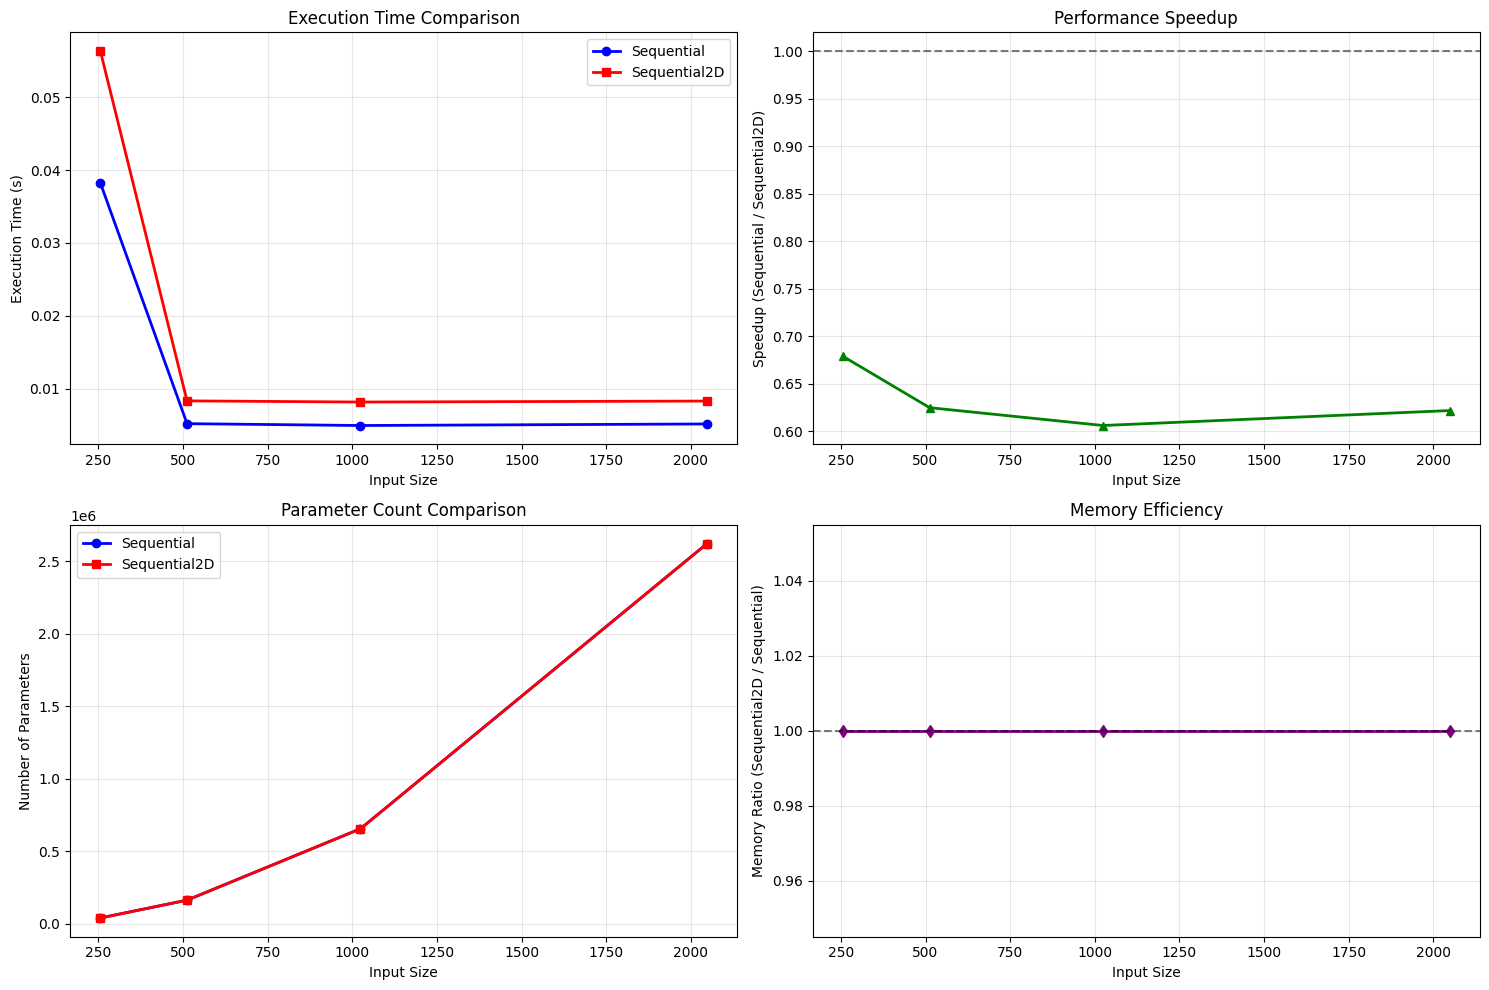

In [7]:
def plot_performance_comparison():
    """
    Visualize performance comparison results
    """
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot 1: Execution time comparison
    ax1.plot(benchmark_results['input_size'], benchmark_results['sequential_time'], 
             'b-o', label='Sequential', linewidth=2, markersize=6)
    ax1.plot(benchmark_results['input_size'], benchmark_results['sequential2d_time'], 
             'r-s', label='Sequential2D', linewidth=2, markersize=6)
    ax1.set_xlabel('Input Size')
    ax1.set_ylabel('Execution Time (s)')
    ax1.set_title('Execution Time Comparison')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Speedup
    ax2.plot(benchmark_results['input_size'], benchmark_results['speedup'], 
             'g-^', linewidth=2, markersize=6)
    ax2.axhline(y=1, color='k', linestyle='--', alpha=0.5)
    ax2.set_xlabel('Input Size') 
    ax2.set_ylabel('Speedup (Sequential / Sequential2D)')
    ax2.set_title('Performance Speedup')
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Parameter count comparison
    ax3.plot(benchmark_results['input_size'], benchmark_results['sequential_params'], 
             'b-o', label='Sequential', linewidth=2, markersize=6)
    ax3.plot(benchmark_results['input_size'], benchmark_results['sequential2d_params'], 
             'r-s', label='Sequential2D', linewidth=2, markersize=6)
    ax3.set_xlabel('Input Size')
    ax3.set_ylabel('Number of Parameters')
    ax3.set_title('Parameter Count Comparison')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Memory efficiency
    memory_ratio = benchmark_results['sequential2d_params'] / benchmark_results['sequential_params']
    ax4.plot(benchmark_results['input_size'], memory_ratio, 
             'purple', linewidth=2, marker='d', markersize=6)
    ax4.axhline(y=1, color='k', linestyle='--', alpha=0.5)
    ax4.set_xlabel('Input Size')
    ax4.set_ylabel('Memory Ratio (Sequential2D / Sequential)')
    ax4.set_title('Memory Efficiency')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_performance_comparison()

## Part 4: Advanced Sequential2D Features

Let's explore some advanced features unique to Sequential2D.

In [8]:
def demonstrate_sparse_connectivity():
    """
    Show how Sequential2D can handle sparse connectivity patterns
    """
    print("Creating Sequential2D with sparse connectivity...")
    
    # Create a network with sparse connections using MaskedLinear
    in_features_list = [100, 50, 25]
    out_features_list = [50, 25, 10]
    
    # Use configuration-based creation with sparse blocks
    config = {
        "in_features_list": in_features_list,
        "out_features_list": out_features_list,
        "block_types": [
            ['MaskedLinear', None, None],
            ['MaskedLinear', 'MaskedLinear', None],
            [None, 'MaskedLinear', 'Linear']
        ],
        "block_kwargs": [
            [{'sparsity': 0.5}, None, None],
            [{'sparsity': 0.3}, {'sparsity': 0.7}, None], 
            [None, {'sparsity': 0.2}, None]
        ]
    }
    
    try:
        sparse_net = Sequential2D.from_config(config)
        
        # Count parameters and sparsity
        total_params = sum(p.numel() for p in sparse_net.parameters())
        total_weights = sum(p.numel() for name, p in sparse_net.named_parameters() if 'weight' in name)
        
        print(f"Sparse network created successfully!")
        print(f"Total parameters: {total_params}")
        
        # Test forward pass
        test_input = torch.randn(16, sum(in_features_list))
        output = sparse_net(test_input)
        print(f"Input shape: {test_input.shape}")
        print(f"Output shape: {output.shape}")
        
    except Exception as e:
        print(f"Note: Sparse connectivity requires proper MaskedLinear configuration")
        print(f"Error: {e}")
        
        # Create a simpler version without sparsity constraints
        blocks = [
            [nn.Linear(100, 50), None, None],
            [nn.Linear(50, 50), nn.Linear(50, 25), None],
            [None, nn.Linear(25, 25), nn.Linear(25, 10)]
        ]
        
        sparse_net = Sequential2D(in_features_list, out_features_list, blocks)
        test_input = torch.randn(16, sum(in_features_list))
        output = sparse_net(test_input)
        
        print(f"Alternative network created:")
        print(f"Input shape: {test_input.shape}")
        print(f"Output shape: {output.shape}")
        print(f"Parameters: {sum(p.numel() for p in sparse_net.parameters())}")

demonstrate_sparse_connectivity()

Creating Sequential2D with sparse connectivity...
Sparse network created successfully!
Total parameters: 28535
Input shape: torch.Size([16, 175])
Output shape: torch.Size([16, 85])


In [9]:
def memory_usage_analysis():
    """
    Detailed memory usage analysis
    """
    print("Memory Usage Analysis")
    print("=" * 50)
    
    # Create networks of different complexities
    configurations = [
        ("Simple Chain", [784], [10], [[nn.Linear(784, 10)]]),
        ("Two Layer", [784, 128], [128, 10], 
         [[nn.Linear(784, 128), None], [None, nn.Linear(128, 10)]]),
        ("Complex Multi-path", [784, 256], [256, 128, 10],
         [[nn.Linear(784, 256), nn.Linear(784, 128), nn.Linear(784, 10)],
          [None, nn.Linear(256, 128), nn.Linear(256, 10)]])
    ]
    
    for name, in_feat, out_feat, blocks in configurations:
        net = Sequential2D(in_feat, out_feat, blocks)
        
        # Calculate memory usage
        param_count = sum(p.numel() for p in net.parameters())
        param_memory = sum(p.numel() * p.element_size() for p in net.parameters())
        
        # Test with different batch sizes
        batch_sizes = [1, 16, 64, 256]
        
        print(f"\n{name}:")
        print(f"  Parameters: {param_count:,}")
        print(f"  Parameter memory: {param_memory / 1024:.2f} KB")
        
        for batch_size in batch_sizes:
            test_input = torch.randn(batch_size, sum(in_feat))
            
            # Measure peak memory usage during forward pass
            if torch.cuda.is_available():
                torch.cuda.reset_peak_memory_stats()
                output = net(test_input)
                peak_memory = torch.cuda.max_memory_allocated() / 1024 / 1024  # MB
                print(f"  Batch {batch_size:3d}: {peak_memory:.2f} MB peak GPU memory")
            else:
                output = net(test_input)
                activation_memory = output.numel() * output.element_size() / 1024  # KB
                print(f"  Batch {batch_size:3d}: ~{activation_memory:.2f} KB activation memory")

memory_usage_analysis()

Memory Usage Analysis

Simple Chain:
  Parameters: 7,850
  Parameter memory: 30.66 KB
  Batch   1: 8.12 MB peak GPU memory
  Batch  16: 8.12 MB peak GPU memory
  Batch  64: 8.12 MB peak GPU memory
  Batch 256: 8.12 MB peak GPU memory

Two Layer:
  Parameters: 101,770
  Parameter memory: 397.54 KB
  Batch   1: 8.12 MB peak GPU memory
  Batch  16: 8.12 MB peak GPU memory
  Batch  64: 8.12 MB peak GPU memory
  Batch 256: 8.12 MB peak GPU memory

Complex Multi-path:
  Parameters: 344,756
  Parameter memory: 1346.70 KB
  Batch   1: 8.12 MB peak GPU memory
  Batch  16: 8.12 MB peak GPU memory
  Batch  64: 8.12 MB peak GPU memory
  Batch 256: 8.12 MB peak GPU memory
